## Imports and Installs

### 1. Installs

In [1]:
!pip install roboflow


[notice] A new release of pip is available: 25.0.1 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
# !pip install ultralytics

### 2. Imports

In [2]:
from roboflow import Roboflow
import torch
import numpy as np
from PIL import Image
from pycocotools.coco import COCO
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import os
import cv2
from pathlib import Path
import random
import matplotlib.pyplot as plt

from ultralytics import YOLOWorld

## Datasets

In [ ]:
with open("key.txt", 'r') as f:
    key = f.readline()
key

'v4pDPUOl5s31UwrbNJ4l'

### 1. Cracks Dataset

##### a. Vanilla

In [ ]:
rf = Roboflow(api_key=key)
project = rf.workspace("testing-tccdj").project("cracks-3ii36-anuok")
version = project.version(1)
dataset = version.download("coco")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to cracks-1 in coco:: 100%|██████████| 5376/5376 [00:01<00:00, 4353.54it/s]


##### b. Orientation Augmentation

In [3]:
# with Augmentation of orientation
rf = Roboflow(api_key=key)
project = rf.workspace("testing-tccdj").project("cracks-3ii36-anuok")
version = project.version(2)
dataset = version.download("coco")


loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to cracks-2 in coco:: 100%|██████████| 15422/15422 [00:06<00:00, 2557.71it/s]


### 2. Segment Joints Dataset

In [4]:
rf = Roboflow(api_key=key)
project = rf.workspace("testing-tccdj").project("drywall-join-detect-yrltu")
version = project.version(1)
dataset = version.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to Drywall-Join-Detect-1 in yolov8:: 100%|██████████| 85195/85195 [00:22<00:00, 3870.14it/s]


## Models

### CLIPSeg for Segmentation

In [6]:
# Define folder Paths
train_path, val_path, test_path = r"cracks-2/train", r"cracks-2/valid", r"cracks-2/test"

In [7]:
prompt_cracks = ["segment wall crack", "segment crack", "jagged structural crack", "wall crack", "plaster surface fracture", "plaster Fracture", "crack in drywall"]

# Load COCO annotations masks
coco = COCO(f"{train_path}/_annotations.coco.json")
coco.loadImgs(321)[0]['file_name']

loading annotations into memory...
Done (t=0.60s)
creating index...
index created!


'crack272_jpg.rf.596c7cc10d6c9bfe5fec2546d2912d8e.jpg'

##### Custom Dataset Class

In [ ]:
class CrackCOCODataset(Dataset):
    def __init__(self, img_dir, ann_file, processor, prompt="cracks"):
        self.coco = COCO(ann_file)
        self.img_dir = img_dir
        self.ids = list(self.coco.imgs.keys())
        self.processor = processor
        self.prompt = prompt

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]

        # Load and convert image
        image = Image.open(os.path.join(self.img_dir, img_info['file_name'])).convert("RGB")

        # Create Binary Mask from COCO Polygons
        ann_ids = self.coco.getAnnIds(imgIds=img_id)
        anns = self.coco.loadAnns(ann_ids)
        mask = np.zeros((img_info['height'], img_info['width']))
        for ann in anns:
            # Check if segmentation data is present, non-empty, and valid
            if ann.get('segmentation') and len(ann['segmentation']) > 0:
                is_valid_segmentation = True
                for seg in ann['segmentation']:
                    # Polygons in COCO segmentation are typically a list of floats (x1, y1, x2, y2, ...)
                    # A valid polygon needs at least 3 points, so 6 numbers.
                    if not isinstance(seg, list) or len(seg) < 6:
                        is_valid_segmentation = False
                        break
                if is_valid_segmentation:
                    mask = np.maximum(mask, self.coco.annToMask(ann))

        # Preprocessing via CLIPSegProcessor
        # This handles normalization and resizing to 352x352
        if isinstance(self.prompt, list) and len(self.prompt) > 0:
            # Assign higher weights to the first two prompts
            # Example: first two prompts get a weight of 2, others get 1.
            weights = []
            if len(self.prompt) >= 2:
                weights.append(2) # Weight for the first prompt
                weights.append(2) # Weight for the second prompt
                for _ in range(len(self.prompt) - 2):
                    weights.append(1) # Weight for remaining prompts
            elif len(self.prompt) == 1:
                weights.append(1) # Weight for the only prompt
            selected_prompt = random.choices(self.prompt, weights=weights, k=1)[0]
        else:
            selected_prompt = self.prompt

        inputs = self.processor(text=selected_prompt, images=[image], padding="max_length", return_tensors="pt")

        # Ground Truth Mask Processing
        # Resize to 352x352 to match the model's output resolution
        target_mask = Image.fromarray((mask * 255).astype(np.uint8)).resize((352, 352), resample=Image.NEAREST)
        target_mask = torch.tensor(np.array(target_mask) / 255.0, dtype=torch.float32)

        return {
            "pixel_values": inputs["pixel_values"].squeeze(0),
            "input_ids": inputs["input_ids"].squeeze(0),
            "attention_mask": inputs["attention_mask"].squeeze(0),
            "labels": target_mask
        }


def compute_metrics(logits, labels, threshold=0.5):
    preds = (torch.sigmoid(logits) > threshold).float()
    intersection = (preds * labels).sum()
    union = (preds + labels).clamp(0, 1).sum()

    iou = (intersection + 1e-6) / (union + 1e-6)
    dice = (2 * intersection + 1e-6) / (preds.sum() + labels.sum() + 1e-6)

    return iou.item(), dice.item()

##### Model and Processor loading

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined").to(device)

# Initialize DataLoaders for Train and Val
train_ds = CrackCOCODataset(train_path, f"{train_path}/_annotations.coco.json", processor, prompt=prompt_cracks)
val_ds = CrackCOCODataset(val_path, f"{val_path}/_annotations.coco.json", processor, prompt=prompt_cracks)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)

optimizer = AdamW(model.parameters(), lr=5e-5)

The image processor of type `ViTImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Loading weights:   0%|          | 0/462 [00:00<?, ?it/s]

CLIPSegForImageSegmentation LOAD REPORT from: CIDAS/clipseg-rd64-refined
Key                                       | Status     |  | 
------------------------------------------+------------+--+-
clip.vision_model.embeddings.position_ids | UNEXPECTED |  | 
clip.text_model.embeddings.position_ids   | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


loading annotations into memory...
Done (t=0.58s)
creating index...
index created!
loading annotations into memory...
Done (t=0.03s)
creating index...
index created!


##### Train Loop

In [ ]:
for epoch in range(7):
    model.train()
    train_iou, train_dice = 0, 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch} [Train]"):
        optimizer.zero_grad()
        pixel_values = batch["pixel_values"].to(device)
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        outputs = model(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        iou, dice = compute_metrics(outputs.logits, labels)
        train_iou += iou
        train_dice += dice

    # Inside your training loop:
    if epoch % 5 == 0:
        checkpoint_path = f"./checkpoint-epoch-{epoch}"
        model.save_pretrained(checkpoint_path)
        print(f"Saved checkpoint for epoch {epoch}")

    # --- 5. Validation Loop ---
    model.eval()
    val_iou, val_dice = 0, 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch} [Val]"):
            pixel_values = batch["pixel_values"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            iou, dice = compute_metrics(outputs.logits, labels)
            val_iou += iou
            val_dice += dice

    print(f"\nEpoch {epoch} Summary:")
    print(f"Train - mIoU: {train_iou/len(train_loader):.4f}, Dice: {train_dice/len(train_loader):.4f}")
    print(f"Val   - mIoU: {val_iou/len(val_loader):.4f}, Dice: {val_dice/len(val_loader):.4f}\n")

Epoch 0 [Train]: 100%|██████████| 1884/1884 [11:41<00:00,  2.69it/s]


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Saved checkpoint for epoch 0


Epoch 0 [Val]: 100%|██████████| 30/30 [00:10<00:00,  2.80it/s]



Epoch 0 Summary:
Train - mIoU: 0.4767, Dice: 0.6415
Val   - mIoU: 0.4565, Dice: 0.6240



Epoch 1 [Val]: 100%|██████████| 30/30 [00:11<00:00,  2.66it/s]



Epoch 1 Summary:
Train - mIoU: 0.4926, Dice: 0.6563
Val   - mIoU: 0.4568, Dice: 0.6242



Epoch 2 [Val]: 100%|██████████| 30/30 [00:10<00:00,  2.77it/s]



Epoch 2 Summary:
Train - mIoU: 0.5044, Dice: 0.6663
Val   - mIoU: 0.4100, Dice: 0.5781



Epoch 3 [Val]: 100%|██████████| 30/30 [00:11<00:00,  2.71it/s]



Epoch 3 Summary:
Train - mIoU: 0.5188, Dice: 0.6796
Val   - mIoU: 0.4646, Dice: 0.6317



Epoch 4 [Val]: 100%|██████████| 30/30 [00:11<00:00,  2.65it/s]



Epoch 4 Summary:
Train - mIoU: 0.5290, Dice: 0.6882
Val   - mIoU: 0.4830, Dice: 0.6483



Epoch 5 [Train]: 100%|██████████| 1884/1884 [12:16<00:00,  2.56it/s]


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Saved checkpoint for epoch 5


Epoch 5 [Val]: 100%|██████████| 30/30 [00:10<00:00,  2.74it/s]



Epoch 5 Summary:
Train - mIoU: 0.5398, Dice: 0.6975
Val   - mIoU: 0.4855, Dice: 0.6509



Epoch 6 [Val]: 100%|██████████| 30/30 [00:11<00:00,  2.67it/s]


Epoch 6 Summary:
Train - mIoU: 0.5508, Dice: 0.7069
Val   - mIoU: 0.4740, Dice: 0.6396



##### Save Trained Model

In [15]:
# Create a directory for the saved model
save_directory = "./fine_tuned_clipseg"
os.makedirs(save_directory, exist_ok=True)

# 1. Save the model weights and config
model.save_pretrained(save_directory)

# 2. Save the processor (tokenizer + image processor)
processor.save_pretrained(save_directory)

print(f"Model and processor saved successfully to {save_directory}")

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

Model and processor saved successfully to ./fine_tuned_clipseg


##### Load Trained Model

In [17]:
# Path to your saved folder
load_directory = "./fine_tuned_clipseg"

# 1. Load the fine-tuned processor
processor = CLIPSegProcessor.from_pretrained(load_directory)

# 2. Load the fine-tuned model
# Note: Ensure you send it to your GPU (cuda) for faster inference
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CLIPSegForImageSegmentation.from_pretrained(load_directory).to(device)

print("Fine-tuned model loaded and ready for inference!")

Loading weights:   0%|          | 0/462 [00:00<?, ?it/s]

Fine-tuned model loaded and ready for inference!


##### Inference on Test Dataset

In [ ]:
# --- 1. Test Dataset & Inference Class ---
class CLIPSegInference:
    def __init__(self, model, processor, device="cuda"):
        self.model = model.eval().to(device)
        self.processor = processor
        self.device = device

    def evaluate_and_save(self, test_ds, output_dir=f"predictions{prompt_cracks[2]}"):
        Path(output_dir).mkdir(parents=True, exist_ok=True)
        total_iou, total_dice = 0, 0

        print(f"Starting Inference. Saving masks to: {output_dir}")

        with torch.no_grad():
            for idx in range(len(test_ds)):
                # Get raw data (we need original size from COCO)
                img_id = test_ds.ids[idx]
                print(img_id)
                img_info = test_ds.coco.loadImgs(img_id)[0]
                orig_w, orig_h = img_info['width'], img_info['height']

                # Get processed batch
                batch = test_ds[idx]
                pixel_values = batch["pixel_values"].unsqueeze(0).to(self.device)
                input_ids = batch["input_ids"].unsqueeze(0).to(self.device)
                labels = batch["labels"].to(self.device)
                # print(batch['labels'])
                # Forward Pass
                outputs = self.model(pixel_values=pixel_values, input_ids=input_ids)
                logits = outputs.logits # Shape: [1, 352, 352]

                # 1. Calculate Metrics on the 352x352 resolution
                iou, dice = compute_metrics(logits, labels)
                total_iou += iou
                total_dice += dice

                # 2. Format the Prediction Mask
                # Apply sigmoid and threshold
                probs = torch.sigmoid(logits).squeeze().cpu().numpy()
                binary_mask = (probs > 0.5).astype(np.uint8) * 255

                # Resize back to original source image size
                final_mask = cv2.resize(binary_mask, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)

                # 3. Save following the naming rule: {id}__segment_{prompt}.png
                print(test_ds.prompt)
                clean_prompt = test_ds.prompt.replace(" ", "_")
                filename = f"{img_id}__segment_{clean_prompt}.png"
                # prompt only
                #filename = f"{img_id}__{clean_prompt}.png"
                cv2.imwrite(os.path.join(output_dir, filename), final_mask)

        avg_iou = total_iou / len(test_ds)
        avg_dice = total_dice / len(test_ds)

        print(f"\n--- Test Results ---")
        print(f"mIoU Score: {avg_iou:.4f}")
        print(f"Dice Score: {avg_dice:.4f}")
        return avg_iou, avg_dice

# --- 2. Execution ---
# Initialize Test Dataset
test_ds = CrackCOCODataset(test_path, f"{test_path}/_annotations.coco.json", processor, prompt=prompt_cracks[2])

# Run Inference
evaluator = CLIPSegInference(model, processor, device=device)
evaluator.evaluate_and_save(test_ds)

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
Starting Inference. Saving masks to: predictionsjagged structural crack
0
jagged structural crack
1
jagged structural crack
2
jagged structural crack
3
jagged structural crack
4
jagged structural crack
5
jagged structural crack
6
jagged structural crack
7
jagged structural crack
8
jagged structural crack
9
jagged structural crack
10
jagged structural crack
11
jagged structural crack
12
jagged structural crack
13
jagged structural crack
14
jagged structural crack
15
jagged structural crack
16
jagged structural crack
17
jagged structural crack
18
jagged structural crack
19
jagged structural crack
20
jagged structural crack
21
jagged structural crack
22
jagged structural crack
23
jagged structural crack
24
jagged structural crack
25
jagged structural crack
26
jagged structural crack
27
jagged structural crack
28
jagged structural crack
29
jagged structural crack
30
jagged structural crack
31
jagged structur

(0.38846910071888874, 0.5155820809312276)

### Vizualisations

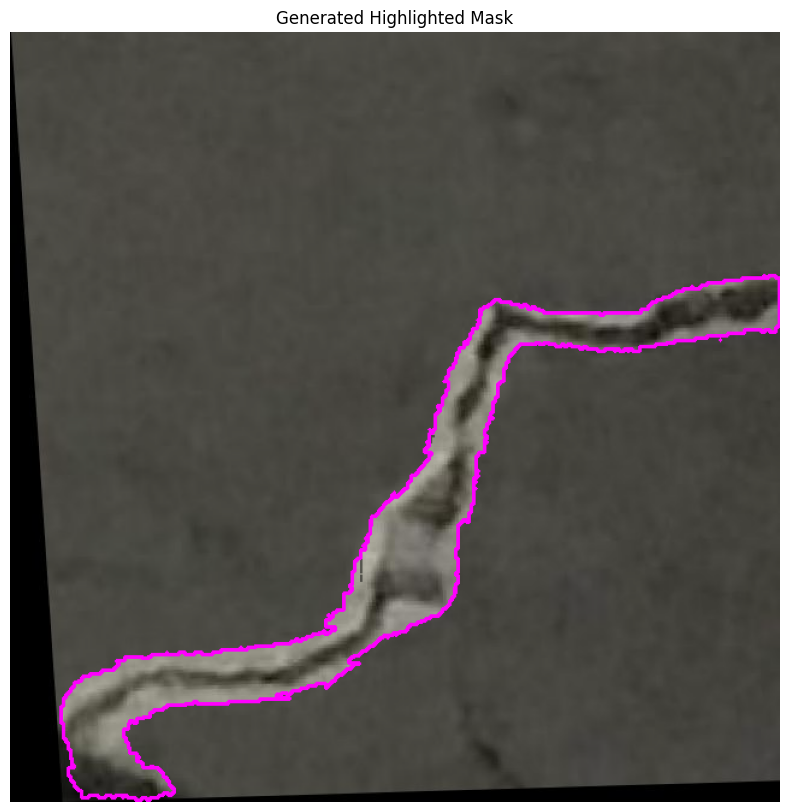

In [51]:
def create_dimmed_background_with_border(image_path, mask_path, output_path=None, 
                                          border_color=(255, 0, 255), # BGR Purple
                                          background_dim_ratio=0.5, # 0.0 is black, 1.0 is original
                                          border_thickness=2):
    """
    Visualizes a mask by dimming the background (black part of mask), 
    keeping the foreground (white part) clear, and drawing a colored border.
    """
    # 1. Load the original image and binary mask
    image = cv2.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if image is None or mask is None:
        raise FileNotFoundError("Check your image and mask file paths.")

    # Ensure mask is strictly binary (0 or 255)
    _, binary_mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # 2. Create the Dimmed Background
    # We multiply the image by the dim_ratio where the mask is 0 (black)
    # This creates a "spotlight" effect on the white part of the mask
    dimmed_image = (image.astype(float) * background_dim_ratio).astype(np.uint8)
    
    # Create the base result: 
    # Use original image pixels where mask is white, dimmed pixels where mask is black
    result = np.where(binary_mask[:, :, None] == 255, image, dimmed_image)

    # 3. Highlight the Border
    # Find the outlines of the white part
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Draw the colored border on top of our dimmed/clear result
    cv2.drawContours(result, contours, -1, border_color, thickness=border_thickness)

    # 4. Save and return
    if output_path:
        cv2.imwrite(output_path, result)
        
    return result

result_img = create_dimmed_background_with_border(img_path, mask_path)
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Generated Highlighted Mask")
plt.show()

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


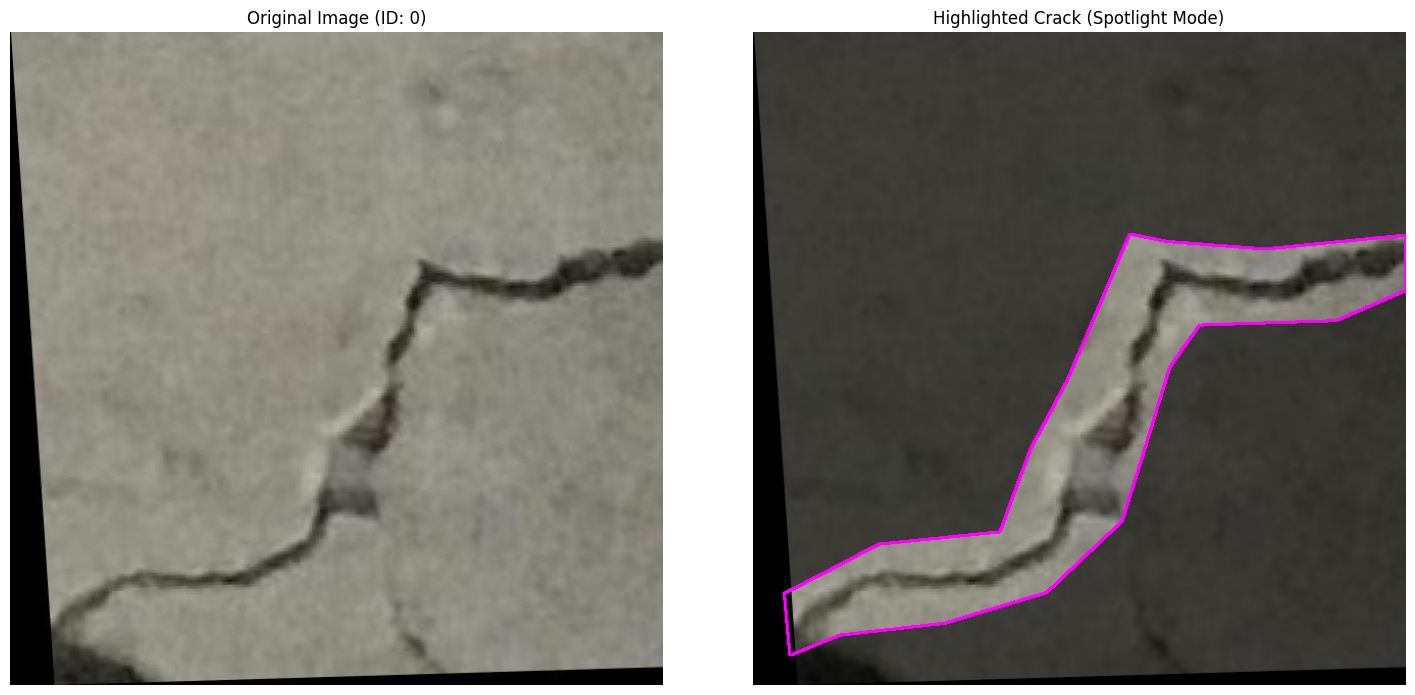

In [56]:
def visualize_mask_comparison(img_id, img_dir=r'cracks-2\test', ann_file=r'cracks-2\test\_annotations.coco.json', background_dim_ratio=0.4, border_color=(255, 0, 255)):
    """
    Displays the original image side-by-side with a 'spotlight' mask visualization.
    The visualization dims the background, keeps the crack clear, and draws a colored border.
    """
    # 1. Initialize COCO and load metadata
    coco = COCO(ann_file)
    img_info = test_ds.coco.loadImgs(img_id)[0]
    img_path = os.path.join(img_dir, img_info['file_name'])
    
    # 2. Load the original image
    image = cv2.imread(img_path)
    if image is None:
        raise FileNotFoundError(f"Could not find image at {img_path}")
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # 3. Generate the Binary Mask from COCO annotations
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    mask = np.zeros((img_info['height'], img_info['width']), dtype=np.uint8)
    for ann in anns:
        mask = np.maximum(mask, coco.annToMask(ann))
    
    # Ensure binary format (0 or 255)
    binary_mask = (mask > 0).astype(np.uint8) * 255

    # 4. Create the 'Spotlight' effect
    # Dim the entire image first
    dimmed_image = (image.astype(float) * background_dim_ratio).astype(np.uint8)
    
    # Replace dimmed pixels with original pixels where the mask is white (255)
    # binary_mask[:, :, None] adds a channel dimension to match the BGR image
    spotlight_result = np.where(binary_mask[:, :, None] == 255, image, dimmed_image)

    # 5. Add the Highlighted Border
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(spotlight_result, contours, -1, border_color, thickness=2)
    
    # Convert BGR to RGB for correct plotting colors
    spotlight_rgb = cv2.cvtColor(spotlight_result, cv2.COLOR_BGR2RGB)

    # 6. Display side-by-side
    plt.figure(figsize=(15, 7))
    
    # Left: Original Image
    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title(f"Original Image (ID: {img_id})")
    plt.axis('off')
    
    # Right: Spotlight Mask
    plt.subplot(1, 2, 2)
    plt.imshow(spotlight_rgb)
    plt.title("Highlighted Crack (Spotlight Mode)")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# --- Usage Example ---
# visualize_mask_comparison(
#     img_id=123, 
#     img_dir='test/images', 
#     ann_file='test/_annotations.coco.json'
# )

visualize_mask_comparison(idx)

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


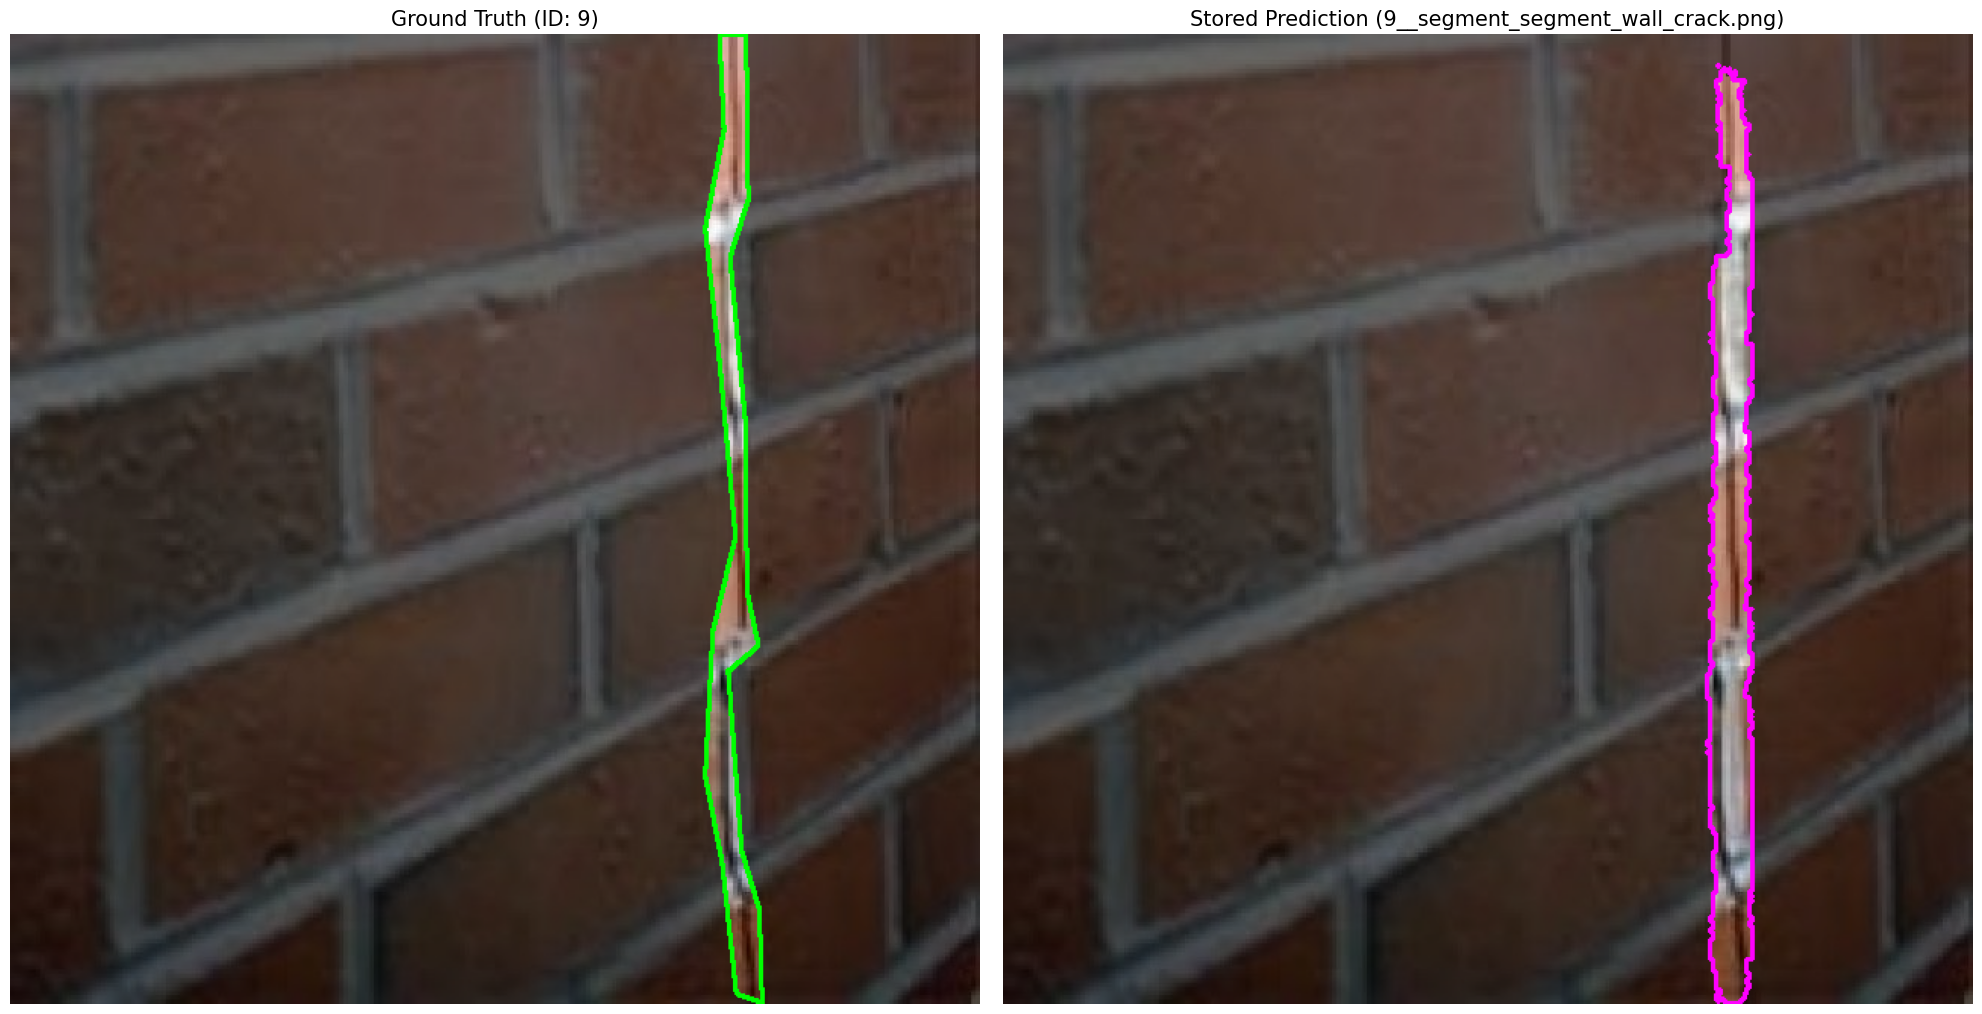

In [68]:
def visualize_gt_vs_stored_pred(img_id, img_dir, ann_file, pred_dir, suffix="__segment_crack.png"):
    """
    Compares Ground Truth from COCO vs. Stored Prediction Masks using a spotlight effect.
    """
    # 1. Load COCO metadata and original image
    coco = COCO(ann_file)
    img_info = test_ds.coco.loadImgs(img_id)[0]
    img_path = os.path.join(img_dir, img_info['file_name'])
    image = cv2.imread(img_path)
    
    if image is None:
        raise FileNotFoundError(f"Original image not found: {img_path}")
    
    orig_h, orig_w = img_info['height'], img_info['width']

    # 2. Generate Ground Truth Mask from COCO
    ann_ids = coco.getAnnIds(imgIds=img_id)
    anns = coco.loadAnns(ann_ids)
    gt_mask = np.zeros((orig_h, orig_w), dtype=np.uint8)
    for ann in anns:
        gt_mask = np.maximum(gt_mask, coco.annToMask(ann))
    gt_mask = (gt_mask > 0).astype(np.uint8) * 255

    # 3. Load the Saved Prediction Mask
    # Pattern: {id}__some_common_suffix.png
    pred_filename = f"{img_id}{suffix}"
    pred_path = os.path.join(pred_dir, pred_filename)
    
    pred_mask = cv2.imread(pred_path, cv2.IMREAD_GRAYSCALE)
    if pred_mask is None:
        raise FileNotFoundError(f"Prediction mask not found: {pred_path}")
    
    # Ensure prediction mask is binary and matches original image size
    if pred_mask.shape[:2] != (orig_h, orig_w):
        pred_mask = cv2.resize(pred_mask, (orig_w, orig_h), interpolation=cv2.INTER_NEAREST)
    _, pred_mask = cv2.threshold(pred_mask, 127, 255, cv2.THRESH_BINARY)

    # 4. Helper for the Spotlight Visualization
    def apply_spotlight(img, mask, border_color=(255, 0, 255)):
        # Dim background (0.4 opacity)
        dimmed = (img.astype(float) * 0.4).astype(np.uint8)
        # Combine: original where mask is white, dimmed where mask is black
        res = np.where(mask[:, :, None] == 255, img, dimmed)
        # Add border
        contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(res, contours, -1, border_color, thickness=2)
        return cv2.cvtColor(res, cv2.COLOR_BGR2RGB)

    # 5. Create both visualizations
    gt_viz = apply_spotlight(image, gt_mask, border_color=(0, 255, 0))    # Green for Ground Truth
    pred_viz = apply_spotlight(image, pred_mask, border_color=(255, 0, 255)) # Purple for Prediction

    # 6. Display Side-by-Side
    fig, axes = plt.subplots(1, 2, figsize=(20, 10))
    
    axes[0].imshow(gt_viz)
    axes[0].set_title(f"Ground Truth (ID: {img_id})", fontsize=15)
    axes[0].axis('off')
    
    axes[1].imshow(pred_viz)
    axes[1].set_title(f"Stored Prediction ({pred_filename})", fontsize=15)
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()


visualize_gt_vs_stored_pred(
    img_id=idx, 
    img_dir=r'cracks-2\test', 
    ann_file='cracks-2/test/_annotations.coco.json', 
    pred_dir='predictions',
    suffix='__segment_segment_wall_crack.png'
)

In [67]:
test_ds = CrackCOCODataset(test_path, f"{test_path}/_annotations.coco.json", processor, prompt=prompt_cracks[2])
idx = random.randint(0, 109)
file = test_ds.coco.loadImgs(idx)[0]['file_name']

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [44]:
min(test_ds.ids), max(test_ds.ids)

(0, 109)

### YOLO

##### Initializations

In [3]:
import yaml
import os


prompt_joints = [
    "segment taping area",
    "segment joint/tape",
    "segment drywall seam",
    "segment drywall tape joint",
    "segment wallboard joint area",
]

# Define the base path to your dataset
dataset_base_path = 'Drywall-Join-Detect-1'

# Define the YAML structure for Ultralytics YOLO
data_config = {
    'path': dataset_base_path, # Base path to dataset
    'train': 'train/images',   # Correct relative path to train images
    'val': 'valid/images',     # Correct relative path to val images
    'test': 'test/images',     # Correct relative path to test images
    'nc': len(prompt_joints),                   # We are detecting a single class: 'drywall joint'
    'names': prompt_joints # Single class name
}

# Define the output path for the data.yaml file
yaml_file_path = os.path.join(dataset_base_path, 'data.yaml')

# Write the dictionary to a YAML file
with open(yaml_file_path, 'w') as f:
    yaml.dump(data_config, f)

print(f"Successfully generated data.yaml at: {yaml_file_path}")
print("Content of data.yaml:")
with open(yaml_file_path, 'r') as f:
    print(f.read())

Successfully generated data.yaml at: Drywall-Join-Detect-1\data.yaml
Content of data.yaml:
names:
- segment taping area
- segment joint/tape
- segment drywall seam
- segment drywall tape joint
- segment wallboard joint area
nc: 5
path: Drywall-Join-Detect-1
test: test/images
train: train/images
val: valid/images



##### Training Loop

In [ ]:
# Load a pretrained YOLOv8s-worldv2 model, this starts the training from scratch
# model = YOLOWorld("yolov8s-worldv2.pt")


# THis uses the last saved model and continues training
model = YOLOWorld(r"runs\detect\train7\weights\last.pt")

# Train the model on the COCO8 example dataset for 100 epochs
results = model.train(data="Drywall-Join-Detect-1/data.yaml", epochs=5, imgsz=640, device=0, batch=8)


Ultralytics 8.4.14  Python-3.10.4 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 3060 Laptop GPU, 6144MiB)
engine\trainer: agnostic_nms=False, amp=True, angle=1.0, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Drywall-Join-Detect-1/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, end2end=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=runs\detect\train6\weights\last.pt, momentum=0.937, mosaic=1.0, multi_scale=0.0, name=train7, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, 

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.


val: Fast image access  (ping: 0.10.1 ms, read: 18.17.2 MB/s, size: 2.0 KB)
val: Scanning D:\Origin(10xContruction)_ass\Drywall-Join-Detect-1\valid\labels.cache... 2048 images, 1146 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 2048/2048  0.0s
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001111, momentum=0.9) with parameter groups 67 weight(decay=0.0), 72 weight(decay=0.0005), 81 bias(decay=0.0)
Plotting labels to D:\Origin(10xContruction)_ass\runs\detect\train7\labels.jpg... 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to D:\Origin(10xContruction)_ass\runs\detect\train7
Starting training for 5 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size
        1/5      2.21G     0.9259      2.066      1.474         12        640: 100% ━━━━━━━━━━━━ 4920/4920 5.8it/s 14:15<0.2s
                 Class     Imag

##### Inference

In [ ]:
# model = YOLOWorld(r"runs\detect\train6\weights\best.pt")
# model.set_classes([prompt_joints[0]])
# result = model.predict(r"Drywall-Join-Detect-1\test\images\2000x1500_47_resized_jpg.rf.46edbd2019c9c2896067d687c6b17850.jpg")
# result[0].show()


image 1/1 d:\Origin(10xContruction)_ass\Drywall-Join-Detect-1\test\images\2000x1500_47_resized_jpg.rf.46edbd2019c9c2896067d687c6b17850.jpg: 640x640 1 segment taping area, 18.1ms
Speed: 5.1ms preprocess, 18.1ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)


In [3]:
def evaluate_yolo_world_segmentation(test_path, model_path, prompts):
    """
    Evaluates a YOLO-World model on a test set using mIoU and Dice.
    
    Args:
        test_path (str): Path to folder containing 'images' and 'labels'
        model_path (str): Path to the trained .pt file
        prompts (list): List of text prompts for the model
    """
    # Initialize model and set the offline vocabulary
    model = YOLOWorld(model_path)
    model.set_classes(prompts)
    
    img_dir = os.path.join(test_path, 'images')
    lbl_dir = os.path.join(test_path, 'labels')
    
    running_iou = 0.0
    running_dice = 0.0
    image_count = 0

    for img_name in os.listdir(img_dir):
        if not img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
            continue
            
        basename = os.path.splitext(img_name)[0]
        lbl_path = os.path.join(lbl_dir, f"{basename}.txt")
        img_path = os.path.join(img_dir, img_name)

        # Skip images where the label file is missing or empty
        if not os.path.exists(lbl_path) or os.path.getsize(lbl_path) == 0:
            continue

        # Load image for dimensions (required to de-normalize YOLO coordinates)
        img = cv2.imread(img_path)
        h, w = img.shape[:2]

        # 1. Generate Ground Truth Mask from YOLO format
        gt_mask = np.zeros((h, w), dtype=np.uint8)
        with open(lbl_path, 'r') as f:
            for line in f:
                parts = list(map(float, line.split()))
                if len(parts) < 5: continue
                
                # YOLO Format: 
                # x_center: 0.5625, y_center: 0.834375, width: 0.875, height: 0.33125 
                _, x_c, y_c, bw, bh = parts
                
                x1 = int((x_c - bw / 2) * w)
                y1 = int((y_c - bh / 2) * h)
                x2 = int((x_c + bw / 2) * w)
                y2 = int((y_c + bh / 2) * h)
                
                # Fill the bounding box area as the "ground truth" segment
                cv2.rectangle(gt_mask, (x1, y1), (x2, y2), 1, -1)

        # 2. Run Model Prediction
        # Open-vocabulary inference using the provided prompts
        results = model.predict(img_path, conf=0.25, verbose=False)
        pred_mask = np.zeros((h, w), dtype=np.uint8)
        
        # Check if the model returned masks (Segmentation variant) 
        # or if we need to convert boxes to masks
        if results[0].masks is not None:
            # For segmentation models: use actual masks
            for mask in results[0].masks.data:
                m = mask.cpu().numpy().astype(np.uint8)
                m_resized = cv2.resize(m, (w, h))
                pred_mask = cv2.bitwise_or(pred_mask, m_resized)
        elif results[0].boxes is not None:
            # For detection models: convert boxes to binary masks
            for box in results[0].boxes.xyxy:
                x1, y1, x2, y2 = map(int, box)
                cv2.rectangle(pred_mask, (x1, y1), (x2, y2), 1, -1)

        # 3. Calculate Metrics
        intersection = np.logical_and(gt_mask, pred_mask).sum()
        union = np.logical_or(gt_mask, pred_mask).sum()
        total_pixels = gt_mask.sum() + pred_mask.sum()
        
        iou = intersection / union if union > 0 else 0
        dice = (2 * intersection) / total_pixels if total_pixels > 0 else 0
        
        running_iou += iou
        running_dice += dice
        image_count += 1

    # Display Results
    if image_count > 0:
        print(f"\nEvaluation Complete for {image_count} images.")
        print(f"Mean IoU (mIoU): {running_iou / image_count:.4f}")
        print(f"Mean Dice Score: {running_dice / image_count:.4f}")
    else:
        print("No valid image/label pairs found to evaluate.")

# Execution
prompt_joints = [
    "segment taping area",
    "segment joint/tape",
    "segment drywall seam",
    "segment drywall tape joint",
    "segment wallboard joint area",
]

evaluate_yolo_world_segmentation(r"Drywall-Join-Detect-1\test", r"runs\detect\train7\weights\best.pt", prompt_joints)


Evaluation Complete for 512 images.
Mean IoU (mIoU): 0.2054
Mean Dice Score: 0.2488


### Vizualizations

In [5]:
from IPython.display import display, clear_output
import ipywidgets as widgets

In [6]:
def visualize_with_widgets(test_path, model_path, prompts):
    """
    Side-by-side visualization using ipywidgets to manage the display area.
    """
    # 1. Setup Model
    model = YOLOWorld(model_path)
    model.set_classes(prompts)
    
    img_dir = os.path.join(test_path, 'images')
    lbl_dir = os.path.join(test_path, 'labels')
    
    # Filter for valid images (non-empty labels)
    valid_images = []
    for f in sorted(os.listdir(img_dir)):
        if f.lower().endswith(('.jpg', '.jpeg', '.png')):
            basename = os.path.splitext(f)[0]
            lbl_path = os.path.join(lbl_dir, f"{basename}.txt")
            if os.path.exists(lbl_path) and os.path.getsize(lbl_path) > 0:
                valid_images.append(f)

    if not valid_images:
        print("No valid images with labels found.")
        return

    # 2. State management
    current_idx = [0] # List used for mutability inside button click
    
    # UI Elements
    out = widgets.Output()
    next_btn = widgets.Button(description="Next Image", button_style='success')
    quit_btn = widgets.Button(description="End Session", button_style='danger')

    def display_current():
        with out:
            clear_output(wait=True)
            img_name = valid_images[current_idx[0]]
            basename = os.path.splitext(img_name)[0]
            img_path = os.path.join(img_dir, img_name)
            lbl_path = os.path.join(lbl_dir, f"{basename}.txt")

            # Load and process
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            h, w = img.shape[:2]

            # Process Ground Truth
            gt_img = img_rgb.copy()
            with open(lbl_path, 'r') as f:
                for line in f:
                    parts = list(map(float, line.split()))
                    _, x_c, y_c, bw, bh = parts
                    x1, y1 = int((x_c - bw/2)*w), int((y_c - bh/2)*h)
                    x2, y2 = int((x_c + bw/2)*w), int((y_c + bh/2)*h)
                    cv2.rectangle(gt_img, (x1, y1), (x2, y2), (0, 255, 0), 4)

            # Process Prediction
            pred_img = img_rgb.copy()
            results = model.predict(img_path, conf=0.25, verbose=False)[0]
            if results.boxes:
                for box in results.boxes:
                    x1, y1, x2, y2 = map(int, box.xyxy[0])
                    conf = float(box.conf[0])
                    cv2.rectangle(pred_img, (x1, y1), (x2, y2), (255, 0, 0), 4)
                    cv2.putText(pred_img, f"{conf:.2f}", (x1, y1-10), 
                                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 0, 0), 3)

            # Plotting
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
            ax1.imshow(gt_img)
            ax1.set_title(f"Ground Truth: {img_name}")
            ax1.axis('off')
            ax2.imshow(pred_img)
            ax2.set_title("YOLO-World Prediction")
            ax2.axis('off')
            plt.show()

    def on_next_clicked(b):
        current_idx[0] += 1
        if current_idx[0] < len(valid_images):
            display_current()
        else:
            with out:
                clear_output()
                print("Reached end of test folder.")
            next_btn.disabled = True

    def on_quit_clicked(b):
        out.close()
        next_btn.disabled = True
        quit_btn.disabled = True
        print("Session ended.")

    next_btn.on_click(on_next_clicked)
    quit_btn.on_click(on_quit_clicked)

    # Display the UI
    display(widgets.HBox([next_btn, quit_btn]), out)
    display_current()

# Usage
visualize_with_widgets(r"Drywall-Join-Detect-1\test", r"runs\detect\train7\weights\best.pt", prompt_joints)

Output()